# **TP Module 2 : Les réseaux de neurones convolutifs**


Concentrons nous maintenant sur les réseaux spécialisés dans le traîtement d'images.

In [0]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

# Splitting 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

2.2.0-rc3
2.3.0-tf


In [0]:
!nvidia-smi

Tue Apr 21 18:01:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
comp = pd.DataFrame()
comp['run'] = []
comp['Perte'] = []
comp['Précision'] = []

## **Introduction : Convolution et Pooling**

La vision assistée par ordinateur (Computer Vision) n'est pas née avec le Deep Learning, c'est un domaine bien plus vieux que ça.

La différence est que précédemment, les filtres et leur poids étaient définis à la main.

Pour vois un peu ce que fait une convolution classique, voici différents filtres déjà définis, et observons ce que cela fait sur l'image suivante.

In [0]:
from sklearn.datasets import load_sample_image

flower = load_sample_image('flower.jpg')/255

# L'image étant sur 3 canaux RGB, transformons la en noir et blanc.
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

grayscale = rgb2gray(flower).astype(np.float32)

(427, 640)

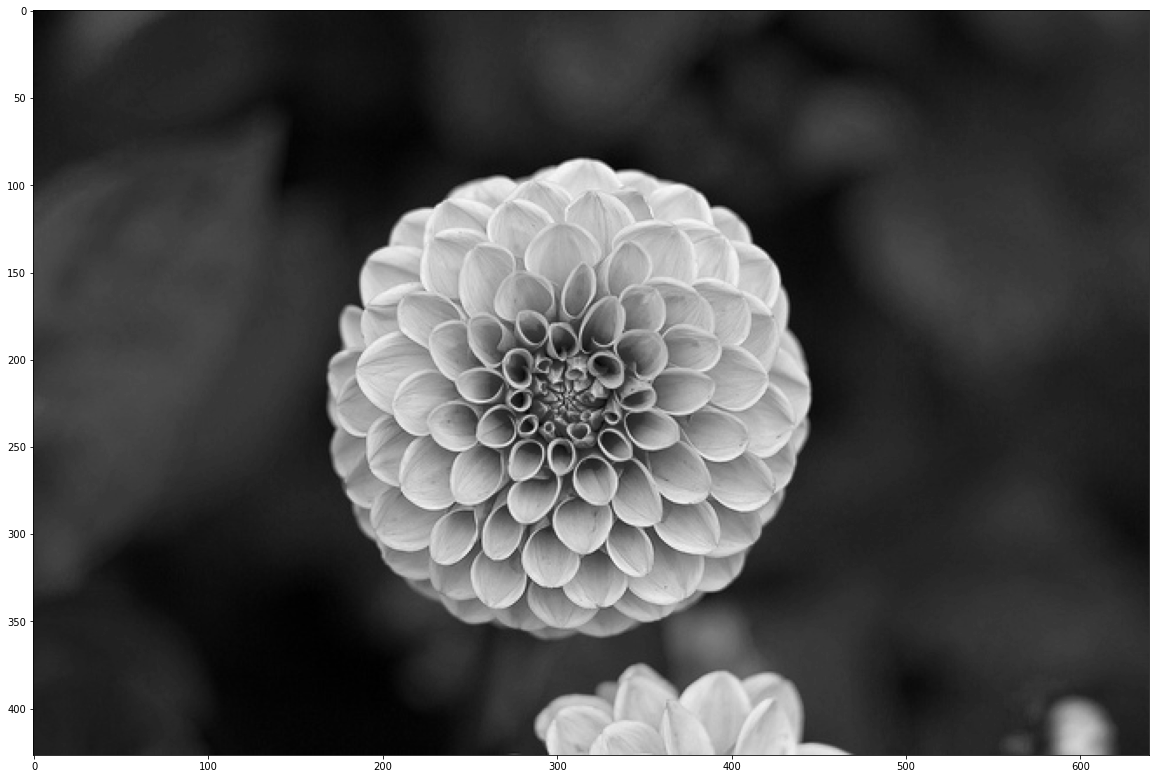

In [0]:
plt.figure(figsize = (20,18))
plt.imshow(grayscale, cmap="gray")
plt.show
grayscale.shape

Vérifions qu'elle a bien été transformée en N&B, ie il n'y plus qu'un seul canal (et donc il n'est pas affiché par `shape`.)

In [0]:
print(flower.shape, grayscale.shape)

(427, 640, 3) (427, 640)


In [0]:
identity = np.array([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]], dtype=np.float32)

contour1 = np.array([[1, 0, -1],
                      [0, 0, 0],
                      [-1, 0, 1]], dtype=np.float32)

contour2 = np.array([[0, 1, 0],
                     [1, -4, 1],
                     [0, 1, 0]], dtype=np.float32)

contour3 = np.array([[-1, -1, -1],
                     [-1, 8, -1],
                     [-1, -1, -1]], dtype=np.float32)

upscaling = np.array([[0, -1, 0],
                     [-1, 5, -1],
                     [0, -1, 0]], dtype=np.float32)

box_blur = np.array([[1/9, 1/9, 1/9],
                     [1/9, 1/9, 1/9],
                     [1/9, 1/9, 1/9]], dtype=np.float32)

gauss_blur = np.array([[1/16, 1/8, 1/16],
                     [1/8, 1/4, 1/8],
                     [1/16, 1/8, 1/6]], dtype=np.float32)

In [0]:
def conv(img,kernel):

    ker_height, ker_width = kernel.shape
    height, width = img.shape

    tf_ker = tf.reshape(kernel, (ker_height, ker_width, 1, 1))

    tf_img = tf.reshape(img, (-1, height, width, 1))

    #print(tf_ker.dtype, tf_gray.dtype)

    outputs= tf.nn.conv2d(tf_img, tf_ker, strides=1, padding="SAME")

    plt.figure(figsize = (20,18))
    plt.imshow(outputs[0,:,:,0], cmap='gray')
    plt.show

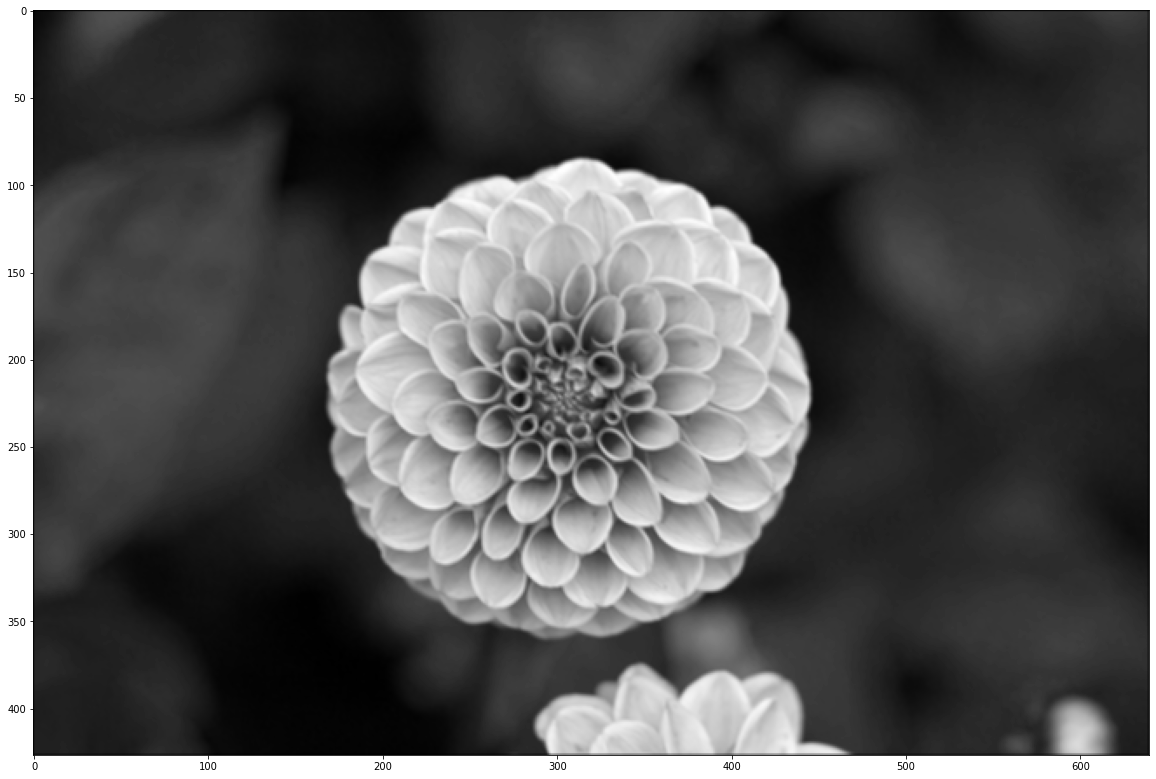

In [0]:
conv(grayscale, gauss_blur)

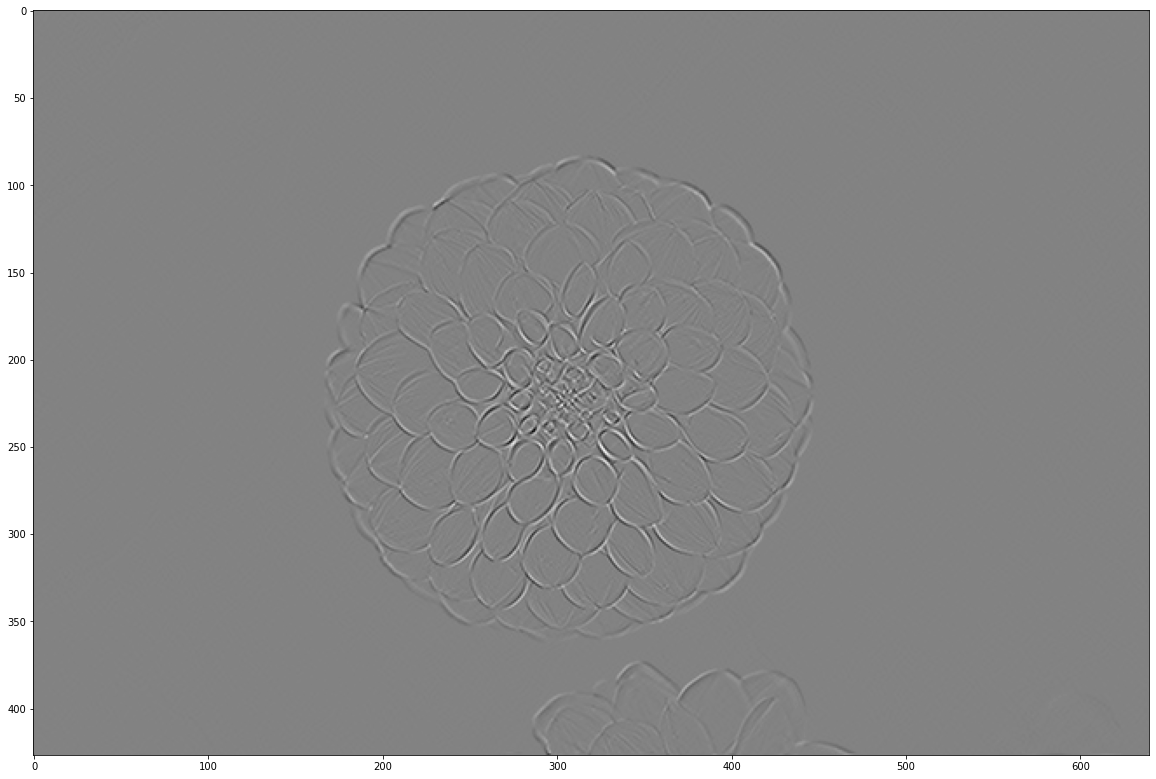

In [0]:
conv(grayscale,contour1)

## **Anatomie d'une couche convolutive, CNN**

Premièrement, importons les librairies dont nous aurons besoin.

In [0]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import optimizers

Avec l'API séquentielle, écrivons un CNN avec uniquement 2 couches convolutives. Evidemment il n'est pas fait pour de l'entraînement, il n'y même pas de couche classifiante, mais utilisons le pour comprendre la structure.

In [0]:
model = models.Sequential([
    Input(shape=(4,4,3)),
    Conv2D(8, (3,3), padding='same', name='conv1'),
    Conv2D(4, (3,3), padding='same', name='conv2')
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 8)           224       
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 4, 4)           292       
Total params: 516
Trainable params: 516
Non-trainable params: 0
_________________________________________________________________


Regardons comment se comporte la première couche convolutive nommée `conv1`.

In [0]:
layer = model.get_layer('conv1')
weights, biases = layer.get_weights()
print(f"Nombre de canaux en entrée : {weights.shape[2]},\n"
      f"Nombre de neurones dans la couche : {weights.shape},\n" #(fs1, fs2, in, out)
      f"Biais : {biases.shape}")

Nombre de canaux en entrée : 3,
Nombre de neurones dans la couche : (3, 3, 3, 8),
Biais : (8,)


### **Exercice**

- Pourquoi le nombre d'entrées de `conv1` est il égal à $3$ ?
- Pour le nombre total de poids de `conv1` est il de $3 \times 3 \times 3 \times 8 = 216$ ?
- Pourquoi n'y a t'il que 8 biais ?

In [0]:
layer = model.get_layer('conv2')
weights2, biases2 = layer.get_weights()
print(f"Nombre d'entrées : {weights2.shape[2]},\n"
      f"Nombre de neurones dans la couche : {weights2.shape},\n"
      f"Biais : {biases2.shape}")

Nombre d'entrées : 8,
Nombre de neurones dans la couche : (3, 3, 8, 4),
Biais : (4,)


### **Exercice**

- Pourquoi le nombre d'entrées de `conv2` est il égal à $8$ ?
- Pour le nombre total de poids de `conv2` est il de $3 \times 3 \times 8 \times 4 = 198$ ?
- Pourquoi n'y a t'il que 4 biais ?

### **Exercice**

En déduire alors à quoi correspond chacune des coordonées dans `weights.shape` et `weights2.shape`.

## **L'opération de pooling**

Comme expliquée, l'opération de pooling est là pour diminuer l'information présente dans les pixels proches, en appliquant une opération d'aggrégation.

Avec `tf.keras` les couches de polling sont appellées via `tf.keras.layers`.

### **Exercice**

Dans la suite est définie une fonction permettant de voir l'effet du pooling sur notre fleur.

**Malheureusement** j'ai oublié comment on appelle les couches

- average pooling 2D,
- maximum pooling 2D.

Regardez la doc de l'API tf.keras.layers et chercher la dénomination de ces deux couches (indice, le nom est dans le menu défilent de droite)

https://www.tensorflow.org/api_docs/python/tf/keras/layers

et placez le nom nom de la couche à la place de `tf.keras.layers.FONCTION`

- L'image que l'on placera dans la variable `img` sera celle définie avant `grayscale`.
- `pool_size` correspond à la taille du filtre de pooling. Commencez avec 2, puis n'hésitez pas à changer voir voir ce que cela fait.

In [0]:
def pool(img,pool_size):
  
    height, width = img.shape
    tf_img = tf.reshape(img, (-1, height, width, 1))

    out=tf.keras.layers.FONCTION(pool_size, padding='valid')(tf_img)
    pool = out[0,:,:,0]

    plt.figure(figsize = (16,16))
    plt.grid(True)
    plt.imshow(pool)
    plt.show

    print(f'Les dimensions avant pooling sont {img.shape} \n'
          f'Les dimensions après pooling sont {pool.shape}')

In [0]:
def pool(img,pool_size):
  
    height, width = img.shape
    tf_img = tf.reshape(img, (-1, height, width, 1))

    out=tf.keras.layers.AvgPool2D(pool_size, padding='valid')(tf_img)
    pool = out[0,:,:,0]

    plt.figure(figsize = (16,16))
    plt.grid(True)
    plt.imshow(pool)
    plt.show

    print(f'Les dimensions avant pooling sont {img.shape} \n'
          f'Les dimensions après pooling sont {pool.shape}')

Les dimensions avant pooling sont (427, 640) 
Les dimensions après pooling sont (106, 160)


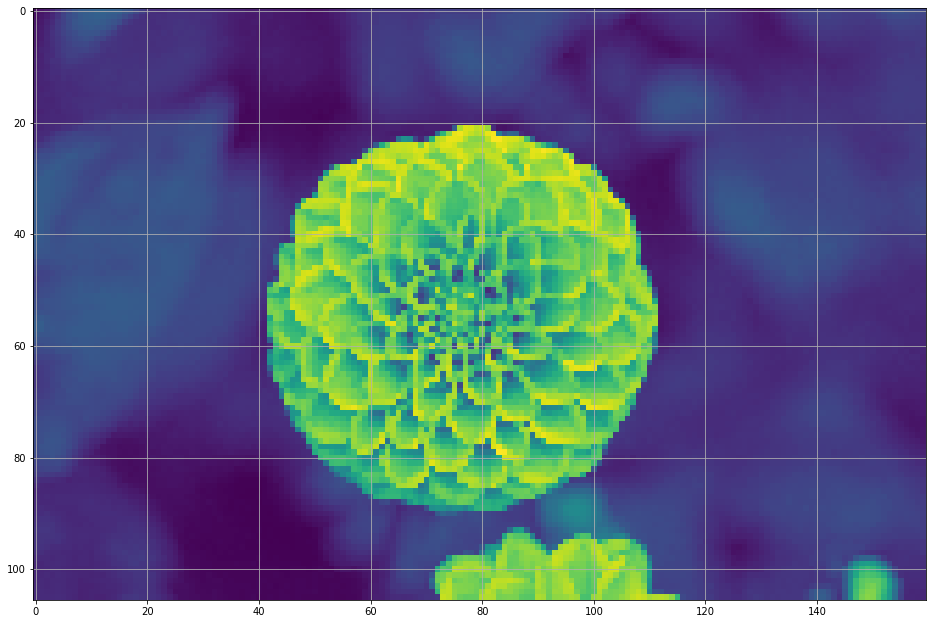

In [0]:
pool(grayscale,4)

In [0]:
def pool(img,pool_size):
  
    height, width = img.shape
    tf_img = tf.reshape(img, (-1, height, width, 1))

    out=tf.keras.layers.MaxPool2D(pool_size, padding='valid')(tf_img)
    pool = out[0,:,:,0]

    plt.figure(figsize = (16,16))
    plt.grid(True)
    plt.imshow(pool)
    plt.show

    print(f'Les dimensions avant pooling sont {img.shape} \n'
          f'Les dimensions après pooling sont {pool.shape}')

Les dimensions avant pooling sont (427, 640) 
Les dimensions après pooling sont (213, 320)


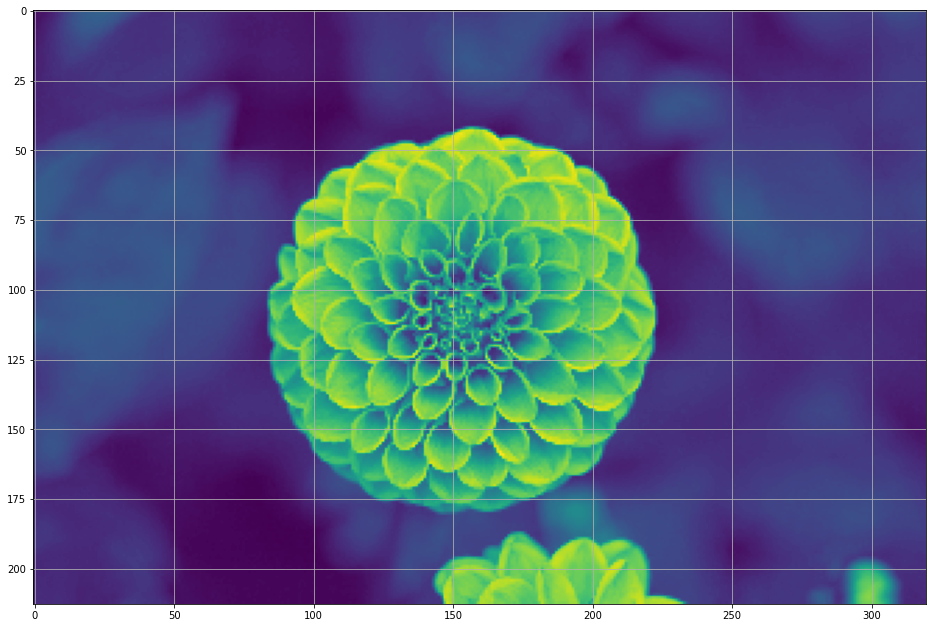

In [0]:
pool(grayscale,2)

Voici un exemple "à la main".

<function matplotlib.pyplot.show>

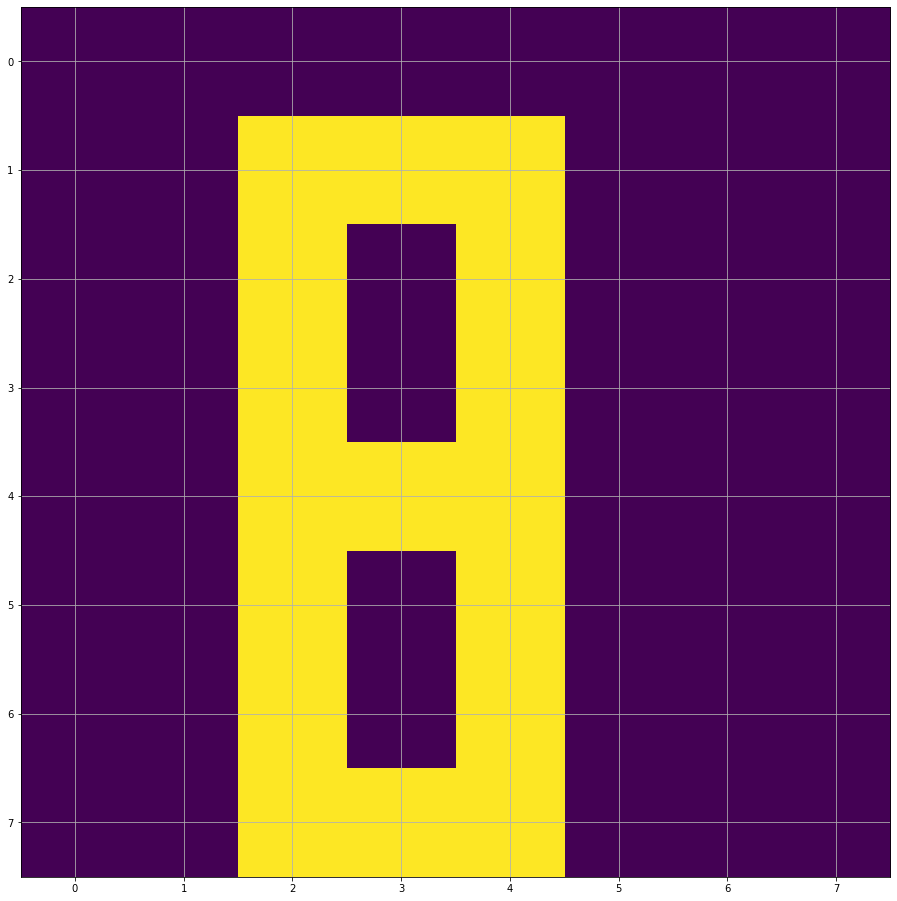

In [0]:
test_img2 = np.array([[0,0,0,0,0,0,0,0],
                       [0,0,1,1,1,0,0,0],
                       [0,0,1,0,1,0,0,0],
                       [0,0,1,0,1,0,0,0],
                       [0,0,1,1,1,0,0,0],
                       [0,0,1,0,1,0,0,0],
                       [0,0,1,0,1,0,0,0],
                       [0,0,1,1,1,0,0,0]], dtype=np.float32)

plt.figure(figsize = (16,16))
plt.grid(True)
plt.imshow(test_img2)
plt.show

(4, 4)


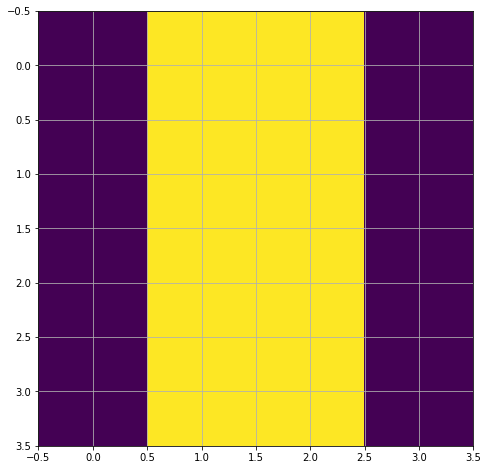

In [0]:
tf_img = tf.reshape(test_img2, (1,8, 8, 1))

out=tf.keras.layers.MaxPool2D(2)(tf_img)
pool = out[0,:,:,0]

plt.figure(figsize = (8,8))
plt.grid(True)
plt.imshow(pool)
plt.show

print(pool.shape)

Effectivement on perd de l'information. Mais qu'est ce qui était le plus le plus important ? le fait que ça ressemble à un 8, ou le fait que que la figure était plus haute que large ? A choisir je préfère la seconde option.

## **Construction et entraînement d'un CNN**

Pour voir la différence entre les réseaux de neurones denses vu à la séance précédente et nos CNN, nous utiliserons de nouveau le dataset CIFAR-10.

Rappelons que le dataset CIFAR-10 comprend 60000 images couleur $32\times32$ réparties en $10$ classes, avec $6000$ images par classe. Il y a $50000$ images d'entraînement et $10000$ images de test.

In [0]:
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.cifar10.load_data()

print(X_train.shape, y_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1)


Les classes présentes dans le dataset sont les suivantes, chacunes représentées par un chiffre de 0 à 9. Dans l'ordre nous avons :

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

C'est aussi un dataset très connu pour faire du benchmark de modèle dans le milieu académique.


In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

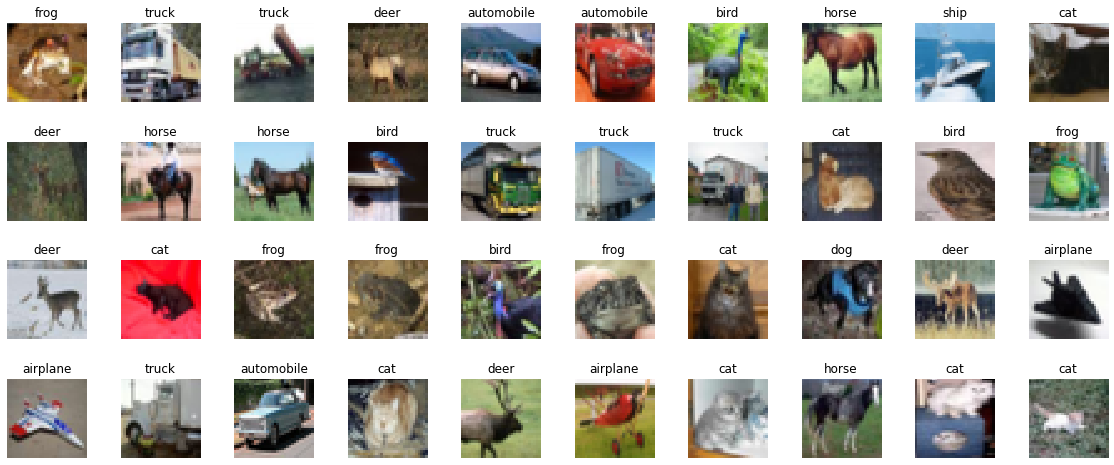

In [0]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index, : , :, :], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[:,0][index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

Mettons le en forme et appliquons directement un One-Hot-Encoding sur les cibles.

In [0]:
X_train = X_train.reshape(-1, 32, 32, 3).astype('float32')
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32')


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=RANDOM_SEED)

X_test = (X_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
X_valid = (X_valid - 127.5) / 127.5 # Normalize the images to [-1, 1]

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_valid_oh = tf.keras.utils.to_categorical(y_valid, num_classes=10)

In [0]:
print(y_train_oh.shape)

(37500, 10)


In [0]:
model = models.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

model.summary()

ValueError: ignored

Vous avez une erreur du type 

'InvalidArgumentError: Negative dimension size caused by subtracting 3 from 2 ...`'

C'est normal, Rappelez vous que par défaut, l'opération de convolution, fait baisser la dimension des features maps. Plus on empile de couches convolutives, plus la dimension baisse, jusqu'à un point où la taille des features maps est tellement petite qu'il n'est plus possible d'appliquer une opération de convolution.

Pour contrer cela, on doit rajouter le paramètre `padding='same'` dans les couches de convolution.

In [0]:
model = models.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

Si l'on souhaite expérimenter, il est évidemment possible de faire passer le modèle dans une fonction.

In [0]:
def define_model(lr=0.001, num_classes=10):

  model = models.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])
  
  model.summary()

  model.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(lr=lr),
                metrics=['accuracy'])

  return model

model = define_model()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 8, 8, 128)       

In [0]:
history = model.fit(X_train, y_train_oh,
                    epochs = 20,
                    batch_size=32,
                    validation_data=(X_valid, y_valid_oh))

Epoch 1/20
1172/1172 [==============================] - 7s 6ms/step - loss: 2.2801 - accuracy: 0.1502 - val_loss: 2.2456 - val_accuracy: 0.2188
Epoch 2/20
1172/1172 [==============================] - 7s 6ms/step - loss: 2.1881 - accuracy: 0.2506 - val_loss: 2.1131 - val_accuracy: 0.2610
Epoch 3/20
1172/1172 [==============================] - 7s 6ms/step - loss: 2.0522 - accuracy: 0.2834 - val_loss: 1.9913 - val_accuracy: 0.2878
Epoch 4/20
1172/1172 [==============================] - 7s 6ms/step - loss: 1.9389 - accuracy: 0.3180 - val_loss: 1.8827 - val_accuracy: 0.3268
Epoch 5/20
1172/1172 [==============================] - 7s 6ms/step - loss: 1.8381 - accuracy: 0.3541 - val_loss: 1.7941 - val_accuracy: 0.3542
Epoch 6/20
1172/1172 [==============================] - 7s 6ms/step - loss: 1.7524 - accuracy: 0.3798 - val_loss: 1.7129 - val_accuracy: 0.3844
Epoch 7/20
1172/1172 [==============================] - 7s 6ms/step - loss: 1.6767 - accuracy: 0.4041 - val_loss: 1.6535 - val_accuracy:

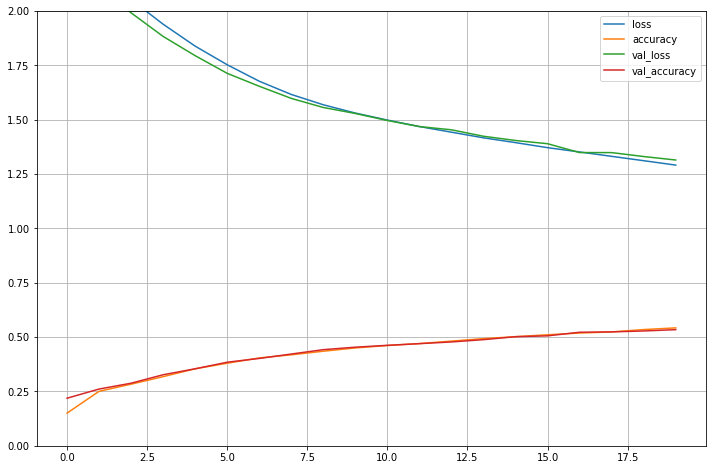

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
loss, accuracy = model.evaluate(X_test,
                                y_test_oh)

comp = comp.append({'run': 'basic_CNN', 'Perte' : loss, 'Précision' : accuracy}, ignore_index=True)
print(comp)

313/313 [==============================] - 1s 3ms/step - loss: 1.3056 - accuracy: 0.5309
Perte : 1.306, Précision : 0.531


Certes, la précision n'est pas terrible, mais ce que l'on a écrit comme modèle ici n'est pas terrible non plus.

Cependant, on peut remarquer une chose.

Avec un modèle composé uniquement de neurones denses, on était en sur-apprentissage dès l'époque 3 ou 4. Sauf qu'ici :

- La fonction de perte, que ce soit sur le dataset d'entraînement, comme sur le dataset de validation, se suivent et ne décrochent pas.
- Idem pour la précision.

Ce qui nous conforte dans notre idée que les CNNs sont fait pour du traitement d'images, et on a même pas encore rajouté la couche classifiante !

Pardon ? La couche classifiante n'est pas celle avec le softmax ?

Il faut comprendre 2 choses :

- Les couches convolutives sont très bonnes pour "extraires des caractéristiques geométriques des images",
- Les couches denses sont là faire "les combinaisons linéaires des vecteurs qui semblent les plus appropriées".

Ainsi, un CNN peut se décomposer en deux parties :

- La partie **d'extraction des caractéristiques** avec les couches convolutives et de pooling.
- la partie **classifiante** avec les neurones denses.

Mais pour pouvoir passer de l'une à l'autre, il faut êêtre capable d'aplanir des matrices, c'est le fameux `flatten`.

Dans la pratique on ne met pas non plus autant de d'opération de pooling entre les couches convolutives.

### **Exercice**

En vous aidant du modèle suivant, construisez le modèle séquentiel avec l'architecture suivante.
```python
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3)),
    Conv2D(64, (3, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3)),
    Conv2D(128, (3, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3)),
    Conv2D(256, (3, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256),
    Dense(128),
    Dense(10, activation='softmax')
```
La fonction d'activation pour passer d'une couche à l'autre est la fonction `relu`. Pour les couches convolutives on fixe `padding=same`.

La compilation et le `model.fit` sont les mêmes que précédemment.

In [0]:
model2 = models.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(128),
    Activation('relu'),
    Dense(10, activation='softmax')
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)        

In [0]:
model2.compile(loss = 'categorical_crossentropy',
             optimizer=tf.keras.optimizers.SGD(lr=0.001),
             metrics=['accuracy'])

history = model2.fit(X_train, y_train_oh,
                     epochs = 20,
                     batch_size=32,
                     validation_data=(X_valid, y_valid_oh))

Epoch 1/20
1172/1172 [==============================] - 14s 12ms/step - loss: 2.2987 - accuracy: 0.1572 - val_loss: 2.2935 - val_accuracy: 0.1993
Epoch 2/20
1172/1172 [==============================] - 14s 12ms/step - loss: 2.2853 - accuracy: 0.2043 - val_loss: 2.2701 - val_accuracy: 0.2142
Epoch 3/20
1172/1172 [==============================] - 14s 12ms/step - loss: 2.2287 - accuracy: 0.2138 - val_loss: 2.1512 - val_accuracy: 0.2456
Epoch 4/20
1172/1172 [==============================] - 14s 12ms/step - loss: 2.0638 - accuracy: 0.2609 - val_loss: 1.9766 - val_accuracy: 0.2802
Epoch 5/20
1172/1172 [==============================] - 14s 12ms/step - loss: 1.9343 - accuracy: 0.2985 - val_loss: 1.8815 - val_accuracy: 0.3065
Epoch 6/20
1172/1172 [==============================] - 14s 12ms/step - loss: 1.8337 - accuracy: 0.3438 - val_loss: 1.7763 - val_accuracy: 0.3580
Epoch 7/20
1172/1172 [==============================] - 14s 12ms/step - loss: 1.7284 - accuracy: 0.3835 - val_loss: 1.6897 -

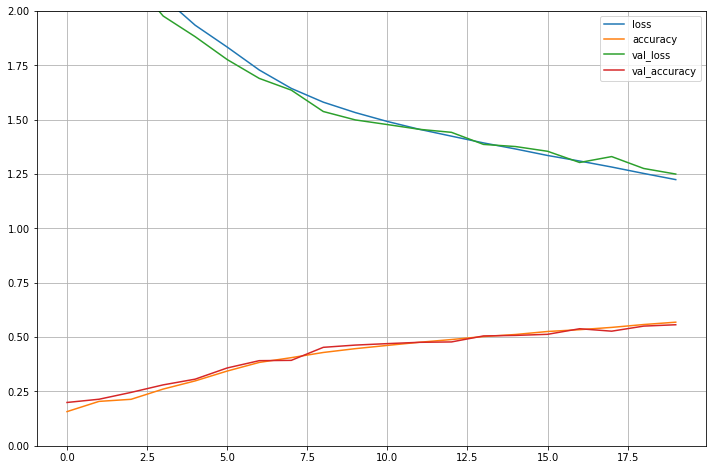

In [0]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
loss, accuracy = model2.evaluate(X_test,
                                y_test_oh)

comp = comp.append({'run': 'basic_CNN_2', 'Perte' : loss, 'Précision' : accuracy}, ignore_index=True)
comp

313/313 [==============================] - 1s 5ms/step - loss: 1.2419 - accuracy: 0.5592


,run,Perte,Précision
0,basic_CNN,1.305569,0.5309
1,basic_CNN_2,1.241935,0.5592


Il est temps de nous attaquer à un modèle plus intéressant : **VGG16**.


## **VGG16**

VGG16 est un réseau de neurones publié en 2015 (du point de vue du deep learning, c'est un papi) par le groupe de recherche **Visual Geometry Group** de l'université d'Oxford.

https://arxiv.org/pdf/1409.1556.pdf

A l'époque, ce réseau était au niveau de l'état de l'art, aujourd'hui des modèles plus rapides à entraîner et plus précis ont pris sa place, mais **ils sont plus compliqué à coder**, ce qui fait qu'il toujours office de couteau suisse et qu'il est encore utilisé de nos jours.

Dans l'article nous pouvons lire la chose suivante

    [i] “All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity.”

    [ii] “Max-pooling is performed over a 2 × 2 pixel window, with stride 2.”
  
Donc la seule fonction d'activation, hormis celle pour classifier, est `relu`, de plus l'opération de pooling est le MaxPooling2D((2,2)), le stride est de 2.

**Remarque** : Si le stride est le même que la fenêtre de pooling, on a pas à le spécifier.


Concernant l'architecture complète du modèle, je vous renvoie à la dernière section théorique du module 2, ie 

- Le réseau consiste en 5 blocs convolutifs et 3 couches denses.
- Chaque bloc convolutif est constitué de 2 ou plus couches convolutives et d'une couche de max pooling.

### **Exercice**

Ecrivez chacun des blocs de VGG16, **via l'API fonctionnelle**. Pour toutes les couches convolutives, le padding est padding='same'.

**Attention à ne pas oublier les fonctions d'activations !**

### **1er bloc**

- conv2d(64, (3,3))
- conv2d(64, (3,3))
- maxpool



In [0]:
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

### **2e bloc**

- conv2d(128, (3,3))
- conv2d(128, (3,3))
- maxpool

In [0]:
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

### **3e bloc**

- conv2d(256, (3,3))
- conv2d(256, (3,3))
- conv2d(256, (3,3))
- maxpool


In [0]:
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

### **4e bloc**

- conv2d(512, (3,3))
- conv2d(512, (3,3))
- conv2d(512, (3,3))
- maxpool



In [0]:
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

### **5e bloc**

- conv2d(512, (3,3))
- conv2d(512, (3,3))
- conv2d(512, (3,3))
- maxpool



In [0]:
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

### **Couche dense**

- Dense(256)
- Dense(128)
- softmax



In [0]:
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128 activation='relu')(x)
output = Dense(units=10, activation='softmax')(x)


Regroupez tout cela pour construire le modèle.

N'oubliez pas que pour l'API fonctionnelle, on aura besoin des ces lignes de codes suivantes :

- from tensorflow.keras import Model

- model = Model(inputs=input, outputs=output)

- input = Input(shape=(32, 32, 3))

Et n'oubliez pas le `Flatten()`.

In [0]:
input = Input(shape=(32, 32, 3))

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
output = Dense(units=10, activation='softmax')(x)

vgg = tf.keras.Model(inputs=input, outputs=output)

vgg.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0   

**Remarque** : Dans le cas où certains blocs se répètent, ce qui est courant dans les architecture modernes, il est pratique des définir les blocs via des fonctions.

In [0]:
from tensorflow.keras.layers import ReLU

def conv2_relu_max(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    return x

def conv3_relu_max(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    return x

VGG16 se réécrit alors sous la forme plus concese suivante.

In [0]:
input = Input(shape=(32, 32, 3))

x = conv2_relu_max(input, 64, 3)
x = conv2_relu_max(x, 128, 3)
x = conv3_relu_max(x, 256, 3)
x = conv3_relu_max(x, 512, 3)
x = conv3_relu_max(x, 512, 3)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
output = Dense(units=10, activation='softmax')(x)

vgg_short = tf.keras.Model(inputs=input, outputs=output)

vgg_short.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
re_lu_52 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
re_lu_53 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 16, 128)       7385

In [0]:
top5 = tf.keras.metrics.TopKCategoricalAccuracy()

vgg.compile(loss = 'categorical_crossentropy',
            optimizer=tf.keras.optimizers.SGD(lr=0.001),
            metrics=['accuracy',top5]
            )

history = vgg.fit(X_train, y_train_oh,
                  epochs = 20,
                  batch_size=32,
                  validation_data=(X_valid, y_valid_oh))

Epoch 1/20
1172/1172 [==============================] - 44s 37ms/step - loss: 2.3025 - accuracy: 0.1075 - top_k_categorical_accuracy: 0.5094 - val_loss: 2.3025 - val_accuracy: 0.1149 - val_top_k_categorical_accuracy: 0.4927
Epoch 2/20
1172/1172 [==============================] - 43s 37ms/step - loss: 2.3024 - accuracy: 0.1080 - top_k_categorical_accuracy: 0.5159 - val_loss: 2.3025 - val_accuracy: 0.1226 - val_top_k_categorical_accuracy: 0.4886
Epoch 3/20
1172/1172 [==============================] - 43s 37ms/step - loss: 2.3024 - accuracy: 0.1148 - top_k_categorical_accuracy: 0.5209 - val_loss: 2.3025 - val_accuracy: 0.0998 - val_top_k_categorical_accuracy: 0.4886
Epoch 4/20
1172/1172 [==============================] - 43s 37ms/step - loss: 2.3023 - accuracy: 0.1038 - top_k_categorical_accuracy: 0.5143 - val_loss: 2.3024 - val_accuracy: 0.1241 - val_top_k_categorical_accuracy: 0.4915
Epoch 5/20
1172/1172 [==============================] - 44s 37ms/step - loss: 2.3023 - accuracy: 0.1120 

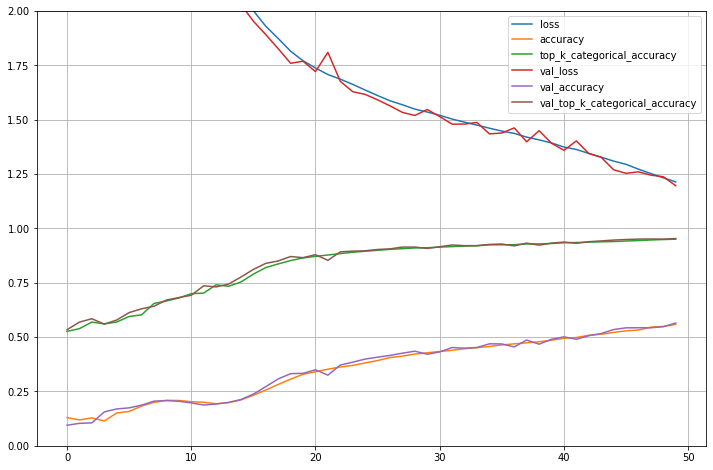

In [0]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

L'architecture est certes plus complexe, mais on a une baisse constante de la perte, et la precision sur le dataset de validation suit de près cette du dataset d'entraînement.

Cependant, de par sa compléxité nous sommes à peine à $20\%$ de précision après $20$ époques (en moyenne, je suis à $54\%$ pour une $50$-aines d'époques), ce qui veut dire que l'on aura besoin de l'entraîner plus longtemps. Mais il n'est surtout pas en sur-apprentissage !

In [0]:
loss, accuracy, top5 = vgg.evaluate(X_test,
                                y_test_oh)

print(f'Perte : {loss:.3f}, Précision : {accuracy:.3f}')

comp = comp.append({'run': 'vgg_scratch', 'Perte' : loss, 'Précision' : accuracy}, ignore_index=True)
comp.head()

313/313 [==============================] - 2s 7ms/step - loss: 1.2073 - accuracy: 0.5611 - top_k_categorical_accuracy: 0.9494
Perte : 1.207, Précision : 0.561


,run,Perte,Précision
0,basic_CNN,1.055519,0.6278
1,basic_CNN_2,1.071909,0.6591
2,vgg_scratch,1.207292,0.5611


On sait coder VGG16, c'est vraiment cool. Mais notre modèle n'est pas optimisé, des gens avec beaucoup plus d'argent, des puissances de calculs et des plus gros dataset l'ont déjà optimisé. 

C'est le principe de transfer learning, pour des tâches similaires, ici de la classification, autant réutilisé les poids déjà entraînés pour, heureusement, Tensorflow nous le permet via

## **Transfer Learning**

Voyons maintenant comment l'on peut booster la précision en utilisant des modèles déjà entraînés par d'autres.

### **A la main**

Dans un premier temps, pour voir un peu comment cela marche nous allons le faire nous même.

Avec le dataset Fashion MNIST, nous allons entraîner notre modèle à ne classifier que $8$ classes sur les $10$ présentes, puis nous réutiliserons les couches déjà entraînées afin de faire la base d'un nouveau modèle pour classifier les deux dernières. On espère que certaines caractéristiques apprises sur les $8$ premières classes pourront nous être utiles pour le reste. 

(60000, 28, 28) (60000,)


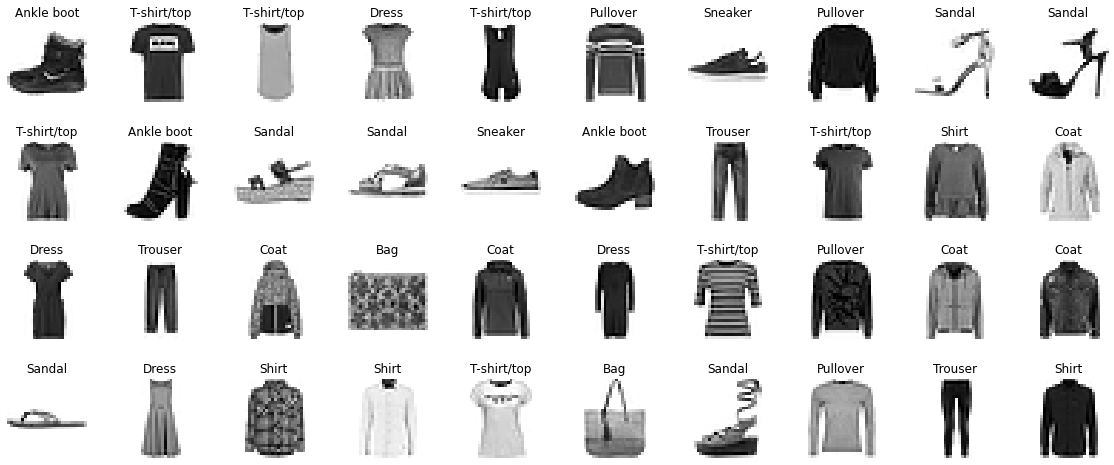

In [0]:
# Téléchargeons fashion_mnist et regardons à quoi il ressemble.
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.fashion_mnist.load_data()

print(X_train.shape, y_train.shape)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index, : , :, ], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [0]:
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=RANDOM_SEED)

X_test = X_test/255
X_train = X_train/255
X_valid = X_valid/255

Définissons la fonction suivante pour séparer notre dataset en 2 tâches distinctes.

In [0]:
def split_dataset(X, y):
    y_8_or_9 = (y == 8) | (y == 9) # "Bag", "Ankle boot"
    y_A = y[~y_8_or_9]
    
    y_B = (y[y_8_or_9] == 9).astype(np.float32) # binary classification : est ce c'est une Ankle boot (classe 9)? (sinon on a le masque True, False)
    return ((X[~y_8_or_9], y_A),
            (X[y_8_or_9], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

#Pour l'exemple, on prend beaucoup moins de données pour la classification binaire.
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [0]:
print(f'X_train_A.shape : {X_train_A.shape} \n'
      f'X_train_B.shape : {X_train_B.shape}')

X_train_A.shape : (35996, 28, 28, 1) 
X_train_B.shape : (200, 28, 28, 1)


In [0]:
set(y_train_A)

{0, 1, 2, 3, 4, 5, 6, 7}

In [0]:
set(y_train_B)

{0.0, 1.0}

In [0]:
#reprenons le CNN classique du début, on l'utilise pour la classification du gros dataset
modelA = models.Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(128),
    Activation('relu'),
    Dense(8, activation='softmax')
])

In [0]:
modelA.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=0.001),
                metrics=["accuracy"])

history = modelA.fit(X_train_A, y_train_A, 
                      epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1125/1125 [==============================] - 11s 10ms/step - loss: 1.8897 - accuracy: 0.3600 - val_loss: 1.1644 - val_accuracy: 0.6103
Epoch 2/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.8761 - accuracy: 0.6611 - val_loss: 0.8080 - val_accuracy: 0.6714
Epoch 3/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.7402 - accuracy: 0.7132 - val_loss: 0.8499 - val_accuracy: 0.6740
Epoch 4/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.6856 - accuracy: 0.7367 - val_loss: 0.6421 - val_accuracy: 0.7622
Epoch 5/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.6437 - accuracy: 0.7553 - val_loss: 0.6457 - val_accuracy: 0.7482
Epoch 6/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.6118 - accuracy: 0.7676 - val_loss: 0.5839 - val_accuracy: 0.7738
Epoch 7/20
1125/1125 [==============================] - 11s 10ms/step - loss: 0.5863 - accuracy: 0.7787 - val_loss: 0.5885 -

Une fois ce premier entraînement fait. On peut sauvegarder le modèle ( larchitecture **et** les poids) de la manière suivante.

In [0]:
modelA.save("modelA.h5")

Reprenons le même modèle, mais utilsons le maintenant pour une tâche de classification binaire.

In [0]:
modelB = models.Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(128),
    Activation('relu'),
    Dense(1, activation='sigmoid')
])

# modelB.summary()

In [0]:
modelB.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = modelB.fit(X_train_B, y_train_B,
                     epochs=20,
                     validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 73ms/step - loss: 0.6915 - accuracy: 0.6700 - val_loss: 0.6913 - val_accuracy: 0.7026
Epoch 2/20
7/7 [==============================] - 0s 57ms/step - loss: 0.6912 - accuracy: 0.7200 - val_loss: 0.6908 - val_accuracy: 0.7430
Epoch 3/20
7/7 [==============================] - 0s 55ms/step - loss: 0.6902 - accuracy: 0.7450 - val_loss: 0.6903 - val_accuracy: 0.7674
Epoch 4/20
7/7 [==============================] - 0s 54ms/step - loss: 0.6896 - accuracy: 0.7850 - val_loss: 0.6898 - val_accuracy: 0.7944
Epoch 5/20
7/7 [==============================] - 0s 56ms/step - loss: 0.6892 - accuracy: 0.8200 - val_loss: 0.6893 - val_accuracy: 0.8291
Epoch 6/20
7/7 [==============================] - 0s 55ms/step - loss: 0.6886 - accuracy: 0.8600 - val_loss: 0.6888 - val_accuracy: 0.8518
Epoch 7/20
7/7 [==============================] - 0s 54ms/step - loss: 0.6881 - accuracy: 0.8750 - val_loss: 0.6883 - val_accuracy: 0.8742
Epoch 8/20
7/7 [===========

Passons à l'étape de transfer learning.

In [0]:
# On recharge le modèle à 8 classes
modelA = keras.models.load_model("modelA.h5")
# On prend toute l'architecture et tous les poids, SAUF la dernière couche de classification
model_B_on_A = keras.models.Sequential(modelA.layers[:-1])
# On ajoute la couche de classification spécifique.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

L'idée est que des poids qui ont été entraîné pour un tâche spécifique, devrait être performant pour une tâche similaire, **même** si les deux datasets sont totalements disjoints.

Des couches entraînées à classifier des vêtements devraient être performants pour en classifier d'autres.

On à généralement 2 étapes.

  - On gèle les poids que l'on va utiliser pour le transfert d'apprentissage, seuls les poids de la couche classifiante formées des neurones denses se mettra à jour lors de l'étape de rétroppropagation.

```python
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False
```

  - On dégèle tout ou partie des poids, pour les spécialiser encore plus pour notre problème.

```python
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True
``` 

In [0]:
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=0.001),
                     metrics=["accuracy"])

In [0]:
# On entraîne avec les poids gelés pour 4 époques.
history = model_B_on_A.fit(X_train_B,
                           y_train_B,
                           epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# on dégèle tout pour 16 époques.
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=0.001),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B,
                           epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 62ms/step - loss: 0.5352 - accuracy: 0.7350 - val_loss: 0.5155 - val_accuracy: 0.7590
Epoch 2/4
7/7 [==============================] - 0s 50ms/step - loss: 0.4763 - accuracy: 0.7900 - val_loss: 0.4701 - val_accuracy: 0.7934
Epoch 3/4
7/7 [==============================] - 0s 51ms/step - loss: 0.4366 - accuracy: 0.8200 - val_loss: 0.4316 - val_accuracy: 0.8241
Epoch 4/4
7/7 [==============================] - 0s 50ms/step - loss: 0.4043 - accuracy: 0.8450 - val_loss: 0.3999 - val_accuracy: 0.8411
Epoch 1/16
7/7 [==============================] - 0s 65ms/step - loss: 0.2326 - accuracy: 0.9400 - val_loss: 0.1440 - val_accuracy: 0.9803
Epoch 2/16
7/7 [==============================] - 0s 55ms/step - loss: 0.1009 - accuracy: 0.9900 - val_loss: 0.0963 - val_accuracy: 0.9883
Epoch 3/16
7/7 [==============================] - 0s 55ms/step - loss: 0.0671 - accuracy: 0.9900 - val_loss: 0.0751 - val_accuracy: 0.9920
Epoch 4/16
7/7 [===============

Voyons ce que cela donne.

In [0]:
_, accB = modelB.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.9370


In [0]:
_, accB_on_A = model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.9960


In [0]:
np.round((100 - (accB*100)) / (100 - (accB_on_A*100)),2)

15.75

Avec un tel pré-entraînement, le taux d'erreur a diminué d'un facteur $15$ ! 

### **Importation des poids de ImageNet**

Imagenet et **LE** dataset de référence pour le benchmark de modèle est l'entraînement des modèles. Comme il contient **plusieurs millions d'images**, l'entraînement est long et coûteux, heureusement les géant de l'Internet comme Google l'ont déjà fait, ce qui veut dire que les poids de ce modèle sont **spécialisés pour la classification**.

Importer des bouts de modèles pré-entraînés se fait via la commande

```python
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
```

`include_top=False` correspond au fait que nous n'utiliserons que la partie convolutive du modèle, c'est à nous d'ajouter la partie classifiante avec les neurones denses et la couches de sortie.

Dans une première approche, on peut figer ces poids (la SGD ne les mettra pas à jour).

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:
conv_base.trainable = False
for layer in conv_base.layers:
    print(f'{layer.name}, Trainable : {layer.trainable}')

input_15, Trainable : False
block1_conv1, Trainable : False
block1_conv2, Trainable : False
block1_pool, Trainable : False
block2_conv1, Trainable : False
block2_conv2, Trainable : False
block2_pool, Trainable : False
block3_conv1, Trainable : False
block3_conv2, Trainable : False
block3_conv3, Trainable : False
block3_pool, Trainable : False
block4_conv1, Trainable : False
block4_conv2, Trainable : False
block4_conv3, Trainable : False
block4_pool, Trainable : False
block5_conv1, Trainable : False
block5_conv2, Trainable : False
block5_conv3, Trainable : False
block5_pool, Trainable : False


Une fois que l'on a fait ça, on peut utiliser cette partie convolutive comme une couche à part entière de notre modèle. Réimportons tout d'abord le dataset cifar10 complet.

In [0]:
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.cifar10.load_data()

X_train = X_train.reshape(-1, 32, 32, 3).astype('float32')
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32')


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=RANDOM_SEED)

X_test = (X_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
X_valid = (X_valid - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Il existe une autre fonction de tf.keras pour transformer de l'ordinal en one_hot

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_valid_oh = tf.keras.utils.to_categorical(y_valid, num_classes=10)

In [0]:
vgg_tf = models.Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128,activation='relu'),
    Dense(10, activation='softmax')
])

vgg_tf.summary()

vgg_tf.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])

history = vgg_tf.fit(X_train, y_train_oh,
                   epochs = 20,
                   batch_size=32,
                   validation_data=(X_valid, y_valid_oh))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1290      
Total params: 14,880,202
Trainable params: 165,514
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
1172/1172 [==============================] - 21s 18ms/step - loss: 2.1444 - accuracy: 0.246

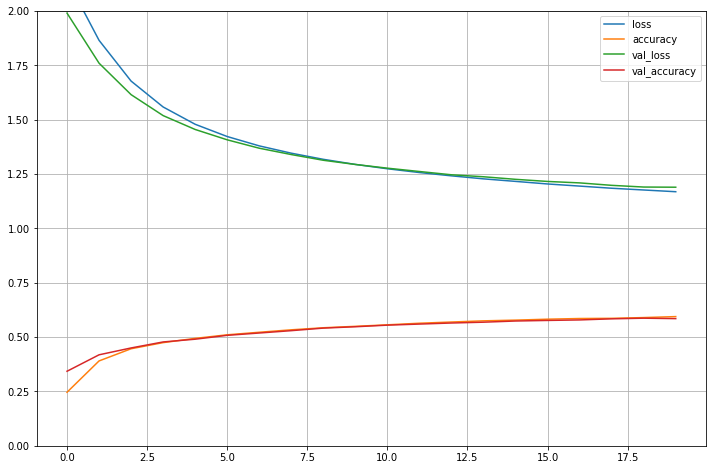

In [0]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

Ca avance doucement, mais on a encore du potentiel pour l'entraîner.

In [0]:
loss, accuracy = vgg_tf.evaluate(X_test,
                                y_test_oh)

comp.append({'run': 'vgg_imagenet', 'Perte' : loss, 'Précision' : accuracy}, ignore_index=True)

313/313 [==============================] - 4s 14ms/step - loss: 1.2080 - accuracy: 0.5758


,run,Perte,Précision
0,adam,1.20797,0.5758


### **Fune Tuning**

Il fois que l'on pense que l'on a tiré tout ce que l'on pouvez extraire des poids que l'on a figé, on peut en débloquer tout ou partie, pour qu'ils se spécialisent sur notre problème de classification. 

#### **Dégel d'une partie**

In [0]:
conv_base.trainable = True

set_trainable = False

# Débloquons tous les poids à partir de la couche nommée `block5_conv1`

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
for layer in conv_base.layers:
    print(f'{layer.name}, Trainable : {layer.trainable}')

input_19, Trainable : False
block1_conv1, Trainable : False
block1_conv2, Trainable : False
block1_pool, Trainable : False
block2_conv1, Trainable : False
block2_conv2, Trainable : False
block2_pool, Trainable : False
block3_conv1, Trainable : False
block3_conv2, Trainable : False
block3_conv3, Trainable : False
block3_pool, Trainable : False
block4_conv1, Trainable : False
block4_conv2, Trainable : False
block4_conv3, Trainable : False
block4_pool, Trainable : False
block5_conv1, Trainable : True
block5_conv2, Trainable : True
block5_conv3, Trainable : True
block5_pool, Trainable : True


#### **Dégel complet**

In [0]:
conv_base.trainable = True
for layer in conv_base.layers:
    print(f'{layer.name}, Trainable : {layer.trainable}')

input_15, Trainable : True
block1_conv1, Trainable : True
block1_conv2, Trainable : True
block1_pool, Trainable : True
block2_conv1, Trainable : True
block2_conv2, Trainable : True
block2_pool, Trainable : True
block3_conv1, Trainable : True
block3_conv2, Trainable : True
block3_conv3, Trainable : True
block3_pool, Trainable : True
block4_conv1, Trainable : True
block4_conv2, Trainable : True
block4_conv3, Trainable : True
block4_pool, Trainable : True
block5_conv1, Trainable : True
block5_conv2, Trainable : True
block5_conv3, Trainable : True
block5_pool, Trainable : True


In [0]:
vgg_tf.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1290      
Total params: 14,880,202
Trainable params: 14,880,202
Non-trainable params: 0
_________________________________________________________________


#### **Lancement du fine tuning**

In [0]:
vgg_tf.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])

history = vgg_tf.fit(X_train, y_train_oh,
                   epochs = 10,
                   batch_size=32,
                   validation_data=(X_valid, y_valid_oh))

Epoch 1/10
1172/1172 [==============================] - 62s 53ms/step - loss: 0.8622 - accuracy: 0.6981 - val_loss: 0.7100 - val_accuracy: 0.7549
Epoch 2/10
1172/1172 [==============================] - 62s 53ms/step - loss: 0.6172 - accuracy: 0.7845 - val_loss: 0.6743 - val_accuracy: 0.7698
Epoch 3/10
1172/1172 [==============================] - 62s 52ms/step - loss: 0.5104 - accuracy: 0.8219 - val_loss: 0.5813 - val_accuracy: 0.7990
Epoch 4/10
1172/1172 [==============================] - 61s 52ms/step - loss: 0.4328 - accuracy: 0.8477 - val_loss: 0.5662 - val_accuracy: 0.8050
Epoch 5/10
1172/1172 [==============================] - 61s 52ms/step - loss: 0.3738 - accuracy: 0.8669 - val_loss: 0.5580 - val_accuracy: 0.8136
Epoch 6/10
1172/1172 [==============================] - 61s 52ms/step - loss: 0.3223 - accuracy: 0.8858 - val_loss: 0.5671 - val_accuracy: 0.8162
Epoch 7/10
1172/1172 [==============================] - 61s 52ms/step - loss: 0.2785 - accuracy: 0.9022 - val_loss: 0.5446 -

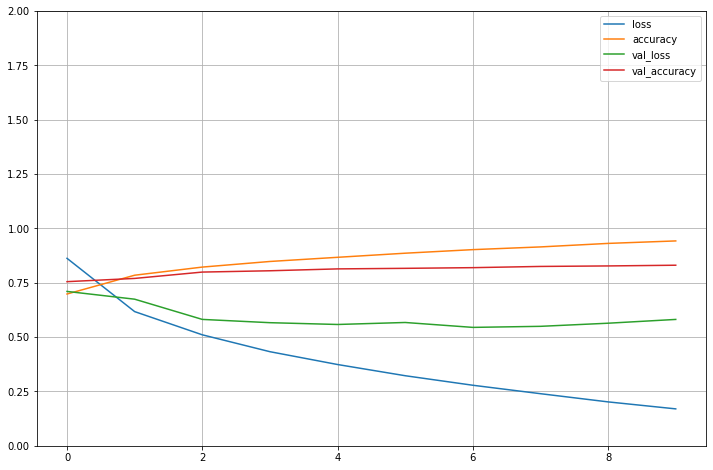

In [0]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
loss, accuracy = vgg_tf.evaluate(X_test,
                                y_test_oh)

comp = comp.append({'run': 'vgg_tf_tuned', 'Perte' : loss, 'Précision' : accuracy}, ignore_index=True)
comp